In [3]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [4]:
from dataset_creation import dataset_creator as data_generator
from feature_extract import turntake_extractor as feat_extractor
import constants

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


In [5]:
# TEST Variables
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
zero_mean = False
from_store= True
filter_missing_data=True
transform_features=False
add_interactions=False
indiv_missing_data=['1_018_35', '2_006_15', '2_006_33', '2_011_29', '2_036_35', '2_044_8', '2_044_30', '3_004_37', '3_007_11', '3_052_27', '3_052_28', '3_058_25', '3_060_1', '3_068_15']
group_missing_data=['1_018', '2_006', '2_006', '2_011', '2_036', '2_044', '2_044', '3_004', '3_007', '3_052', '3_052', '3_058', '3_060', '3_068']

manifest="indiv"
if manifest == "indiv":
    features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.indiv_tt_X_path
    missing_data=indiv_missing_data
else:
    features = ["var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
    store_file=constants.group_tt_X_path
    missing_data=group_missing_data

In [6]:
# Annotation Reader
reliable_ids, reliable_convqs, reliable_kappas = data_generator.get_annotation_realiable_labels(agreeability_thresh, manifest, annotators, zero_mean)
print("Total Groups in Analysis - " + str(len(reliable_ids)))

ZERO-MEAN Technique ? - False


/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


ZERO-MEAN Technique ? - False
Total Groups in Analysis - 273


In [7]:
# Get Turn-Taking feaures for IDs (group/ indiv)
if from_store:
    tt_X = pd.read_csv(store_file, sep=',', header=None).values
#     tt_X.columns = features
#     tt_X.set_index(reliable_ids)
else:
    tt_X = feat_extractor.get_tt_dataset_feats_for(reliable_ids, features, manifest)

In [8]:
# Save Features
if not from_store:
    # Save Dataset -- tt_X
    np.savetxt(store_file, tt_X, delimiter=",")

In [9]:
# Transform Features
if transform_features:
    from sklearn.preprocessing import StandardScaler
    tt_X = StandardScaler().fit_transform(tt_X)
    reliable_convqs = StandardScaler().fit_transform(np.array(reliable_convqs).reshape(-1, 1))

In [10]:
# Get groups sizes (for indiv and group)
group_sizes = data_generator.get_group_sizes_for_ids(reliable_ids, manifest)

In [11]:
#Dataset Prep
tt_X = pd.DataFrame(data=tt_X, index=reliable_ids, columns=features) 
tt_X["convq"] = reliable_convqs
tt_X["group_sizes"] = group_sizes

In [12]:
#Filter Dataset - Remove Incompelete Data
print("Before Filter: Feature Set -> " + str(tt_X.shape))
if filter_missing_data:
    final_reliable_ids = [x for x in reliable_ids if x not in missing_data]
    tt_X = tt_X[tt_X.index.isin(final_reliable_ids)]
print("After Filter: Feature Set -> " + str(tt_X.shape))

Before Filter: Feature Set -> (273, 12)
After Filter: Feature Set -> (259, 12)


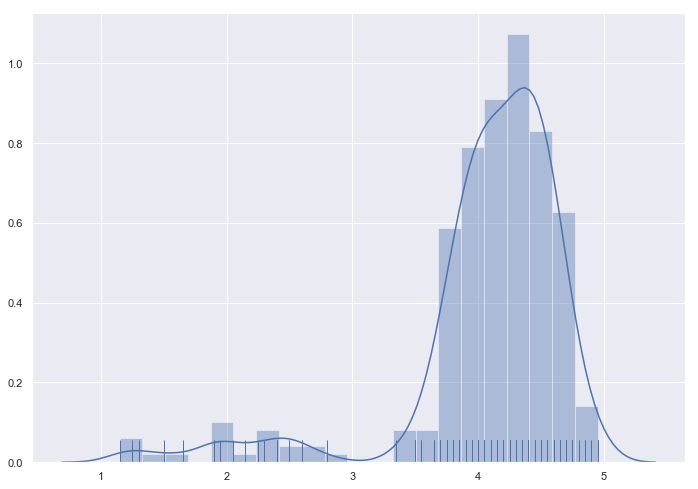

W-Stat = 0.7518290281295776
P-Value-Stat = 5.601505549495714e-20


In [13]:
# Plots - Qualitative Analysis
sns.distplot(reliable_convqs, kde=True, rug=True)
plt.show()

from scipy import stats
# x = stats.norm.rvs(loc=5, scale=3, size=100)
W, p_val = stats.shapiro(reliable_convqs)

print("W-Stat = " + str(W))
print("P-Value-Stat = " + str(p_val))

In [14]:
# Statistical Tests:(Main Question)
# Do Turn-Taking features have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# TT Features can be categorised into three categories -> Equality, Fluency and Synchronisation
#
# (Sub Question)
# Does Conversation Equality have a significant effect on the Perceived Individual's Experience of Conversation Quality?
#  1. Use Features "#turns", "%talk", "mean_turn". 
#
# (Sub Question)
# Does Conversation Fluency have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%silence", "mean_silence", "#bc". 
# 
# (Sub Question)
# Does Conversation Synchronisation have a significant effect on the Perceived Individual's Experience of Conversation Quality?
# 1. Use Features "%overlap", "#suc_interupt", "#un_interupt". 
# 
# For all above questions, after (1), perform below steps,
#  2. Fit a Quantile Least Square Regression model on the features vs the convq score.
#  3. Analyse p-value significance @ p<0.05
#  4. Check the co-efficients for informations.

In [15]:
test_feats=["const", "conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

conv_eq_feats=["const", "group_sizes", "conv_eq"]
conv_fl_feats=["const", "group_sizes", "%silence", "#bc"]
conv_sy_feats=["const", "group_sizes", "%overlap", "#suc_interupt", "#un_interupt"]

full_test_feats=["const", "group_sizes", "conv_eq", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
full_interact_feats=list(full_test_feats)
test_feats=test_feats

if add_interactions:
    # Add interactions
    for curr_feat in full_test_feats:
        if curr_feat not in ["convq", "const", "group_sizes"]:
            interact_pair = "group_sizes" + ":" + curr_feat
            tt_X[interact_pair] = tt_X["group_sizes"].values * tt_X[curr_feat].values
            full_interact_feats.append(interact_pair)

    print("Final Features list for test...")
    print(len(full_interact_feats))
    print(full_interact_feats)

In [16]:
# Experiment Below

# Ordinary Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)")
print()
print()
print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Equality Test ~~~~~~~~~~~~~~~~~~~~~~~")
X = sm.add_constant(tt_X)
model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_eq_feats])
results = model.fit()
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Fluency Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_fl_feats])
results = model.fit()
print(results.summary())
print()
print()

print("~~~~~~~~~~~~~~~~~~~~~~~ Conversation Synchronisation Test ~~~~~~~~~~~~~~~~~~~~~~~")
model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,conv_sy_feats])
results = model.fit()
print(results.summary())

significance @ 0.05/3 = 0.02 after Bonferroni correction for 3 tests (eq, fluency, sync)


~~~~~~~~~~~~~~~~~~~~~~~ Conversation Equality Test ~~~~~~~~~~~~~~~~~~~~~~~
                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:              0.08769
Model:                       QuantReg   Bandwidth:                      0.2638
Method:                 Least Squares   Sparsity:                       0.8728
Date:                Thu, 18 Jun 2020   No. Observations:                  259
Time:                        21:02:30   Df Residuals:                      256
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.4465      0.075     59.574      0.000       4.300       4.593
group_sizes    -0.0723      0.020     -3.

In [17]:
# Quantile Regression
X = sm.add_constant(tt_X)

model = sm.regression.quantile_regression.QuantReg(X["convq"], X.loc[:,full_interact_feats])
results = model.fit(q=.5)
print(results.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  convq   Pseudo R-squared:               0.1027
Model:                       QuantReg   Bandwidth:                      0.2591
Method:                 Least Squares   Sparsity:                       0.8210
Date:                Thu, 18 Jun 2020   No. Observations:                  259
Time:                        21:02:31   Df Residuals:                      251
                                        Df Model:                            7
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5326      0.138     32.842      0.000       4.261       4.804
group_sizes      -0.0781      0.026     -2.966      0.003      -0.130      -0.026
conv_eq           0.1985      0.073      2.735      0.007       0.056       0.341
%silence         -0.1153      0.224  

In [18]:
# Generalised Linear Regression
X = sm.add_constant(tt_X)

model = sm.GLM(X["convq"], X.loc[:,full_test_feats])
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  convq   No. Observations:                  259
Model:                            GLM   Df Residuals:                      251
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                         0.40170
Method:                          IRLS   Log-Likelihood:                -245.33
Date:                Thu, 18 Jun 2020   Deviance:                       100.83
Time:                        21:02:31   Pearson chi2:                     101.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5999      0.213     21.588

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ group_sizes~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


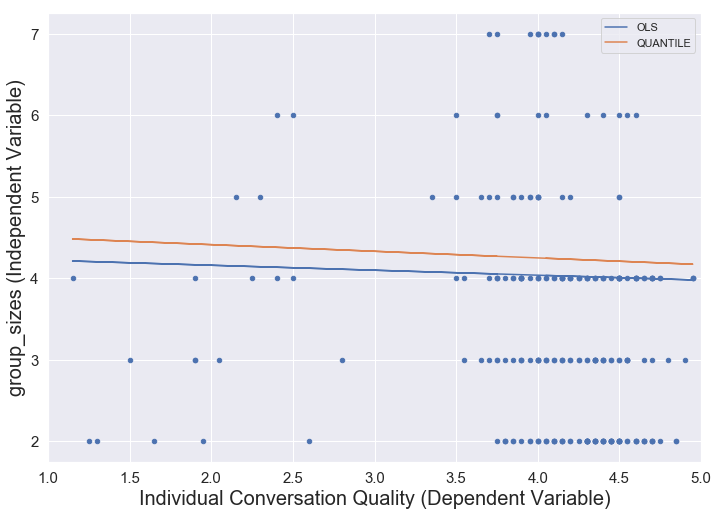

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ conv_eq~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


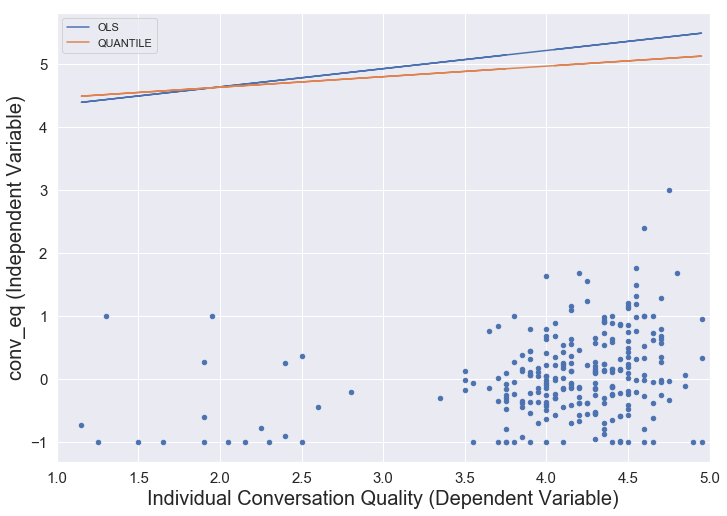

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ %silence~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


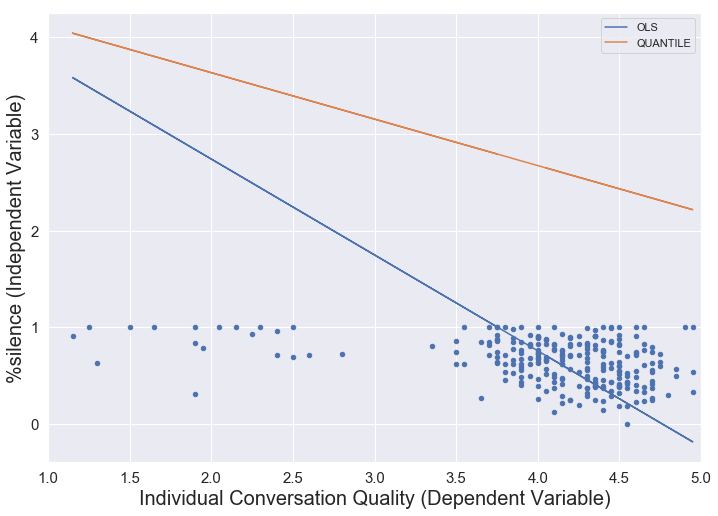

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ #bc~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


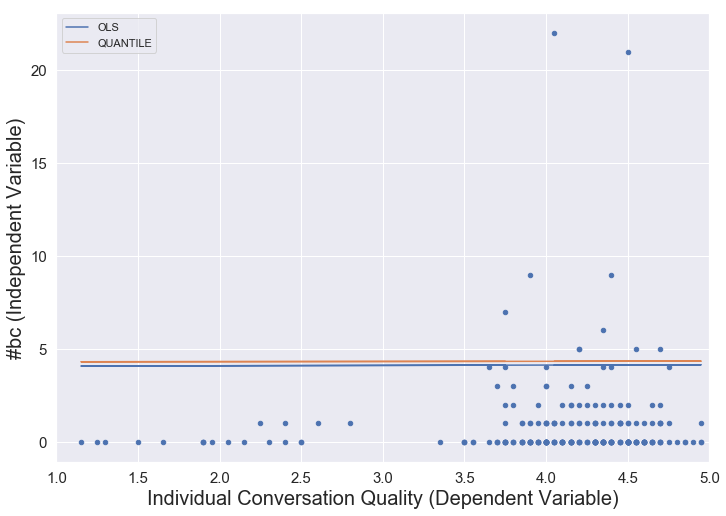

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ %overlap~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


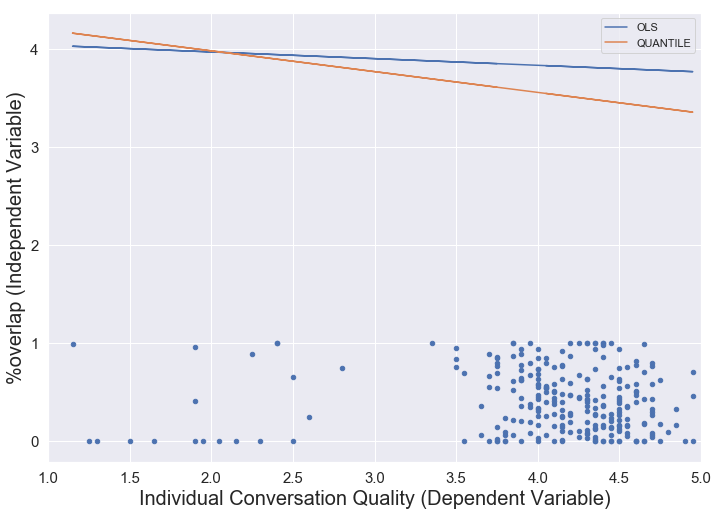

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ #suc_interupt~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


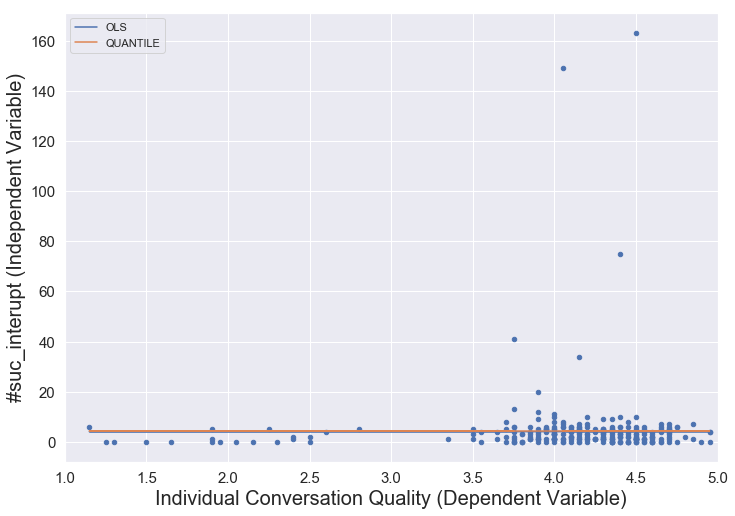

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ #un_interupt~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$


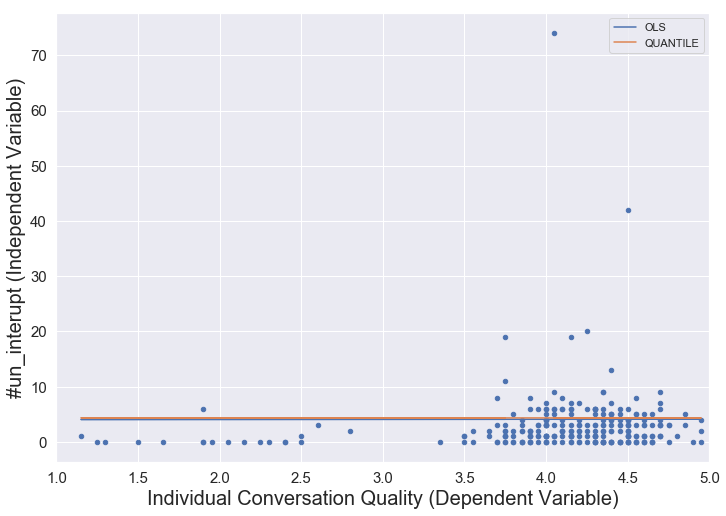

In [28]:
for curr_feat in full_test_feats:
    if curr_feat not in ["convq", "const"]:
        if True:#"_eq" in curr_feat or "silence" in curr_feat:
            print("~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$ " + curr_feat + "~~~~ !!!!!!!!! $$$$$$$$$$$$$$$$$")
            model_ols = sm.OLS(X["convq"], sm.add_constant(X[curr_feat])).fit().params
            model_qnt = sm.regression.quantile_regression.QuantReg(X["convq"], sm.add_constant(X[curr_feat])).fit(0.6).params
            model_glm_gauss = sm.GLM(X["convq"], sm.add_constant(X[curr_feat])).fit().params

            # scatter-plot data
            ax = X.plot(x='convq', y=curr_feat, kind='scatter')

            plt.ylabel(curr_feat + ' (Independent Variable)', fontsize=20)
            plt.xlabel('Individual Conversation Quality (Dependent Variable)', fontsize=20)
            plt.tick_params(labelsize=15)

            # plot regression line on the same axes, set x-axis limits
            ax.plot(X["convq"].values, model_ols["const"] + model_ols[curr_feat] * X["convq"].values)
            ax.plot(X["convq"].values, model_qnt["const"] + model_qnt[curr_feat] * X["convq"].values)
            ax.legend(['OLS', 'QUANTILE'])
            ax.set_xlim([1, 5])
            plt.show()

#             sns.distplot(X[curr_feat], kde=True, rug=True)
#             plt.show()

